# Case Study: Borden

The Borden dataset is a simple, low-resource DEM that forms the basis of the
Borden Benchmark test case.

The test case is based on the original field experiment and hydraulic parameters of
[Abdul and Gillham](https://doi.org/10.1016/0022-1694(89)90177-7), and is used by
[Kollet et al.](https://doi.org/10.1002/2016WR019191) for integrated hydrologic
model intercomparison.

In [3]:
import tinerator as tin

data = tin.ExampleData.Borden

## Borden DEMs

The DEM is available in both 1 meter and 0.5 meter (50 cm) resolutions:

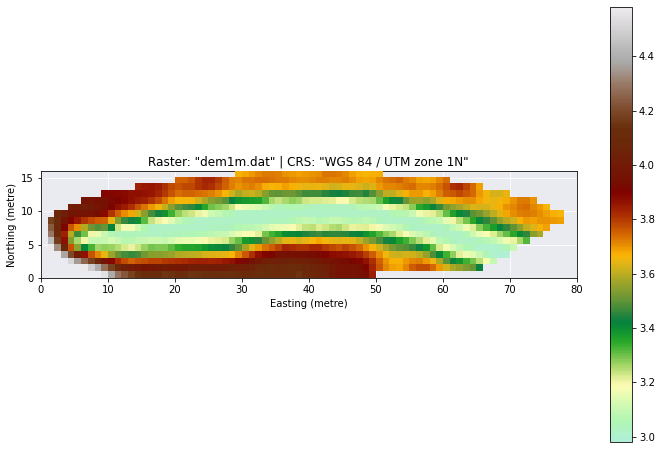

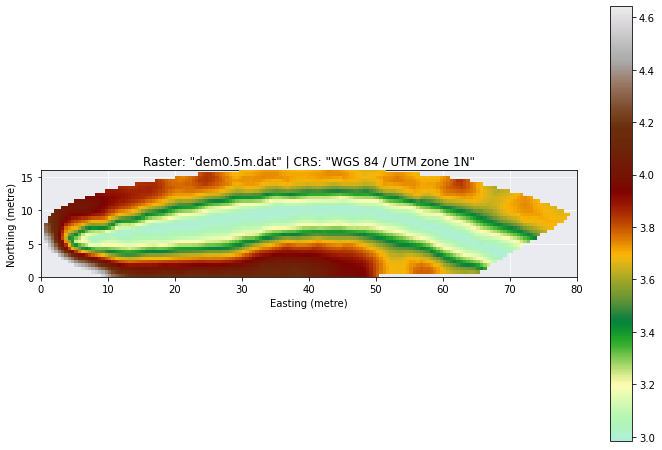

In [7]:
dem_1m = tin.gis.load_raster(data.dem_1m)
dem_1m.fill_depressions()

dem_50cm = tin.gis.load_raster(data.dem_50cm)
dem_50cm.fill_depressions()

dem_1m.plot()
dem_50cm.plot()

## Generating the surface mesh

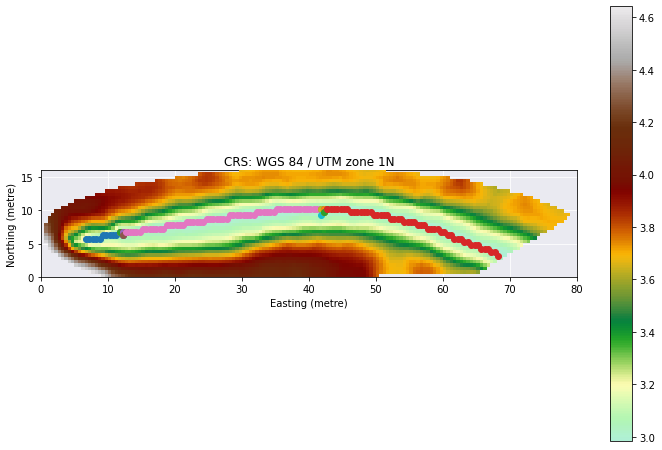

In [26]:
ws_flow = tin.gis.watershed_delineation(dem_50cm, threshold=132., method='D8')
ws_flow.plot(layers=[dem_50cm])

In [28]:
surface_mesh = tin.meshing.triangulate(
    dem_50cm,
    min_edge_length=0.01,
    max_edge_length=0.1,
    method='jigsaw',
    refinement_feature=ws_flow,
    scaling_type='relative',
)

surface_mesh.view(window_size=(400,400))

AttributeError: can't set attribute

In [ ]:
# 50 cm, in 5 cm increments (10 sublayers)
# 1 meter, 20 cm increments (5 sublayers)
# flat bottom, with 5 cells, at z = 0 m

layers = [
    ("constant", 0.5, 5, 1),
    ("constant", 1., 5, 2),
    ("snapped", 0., 5, 3),
]

vol_mesh = tin.meshing.extrude_mesh(surface_mesh, layers)
vol_mesh.view(window_size=(800,800))

In [ ]:
surf = vol_mesh.surface_mesh()

#vol_mesh.save("exodus_test.exo", face_sets=[surf.top_faces, surf.bottom_faces, surf.side_faces])
vol_mesh.save("volume_mesh.vtk")